# MODELO DE PROBABILIDAD DE DEFAULT

## IMPORTAR BIBLIOTECAS

In [1]:
import numpy as np
import pandas as pd
import sys
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_score, confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn import linear_model
import numpy as np
import scipy.stats as stat
from scipy.optimize import minimize_scalar

In [2]:
current_dir = Path().resolve()
sys.path.append(str(current_dir.parent))

from config import RAW_DATA_PATH, PROCESSED_DATA_PATH
pd.options.display.max_columns = None
pd.set_option('display.float_format', '{:,.3f}'.format)  # 2 decimales, sin notación científica


## IMPORTAR DATOS

In [3]:
X_train = pd.read_csv(PROCESSED_DATA_PATH / 'X_train.csv')
X_test = pd.read_csv(PROCESSED_DATA_PATH / 'X_test.csv')

In [4]:
y_train = pd.read_csv(PROCESSED_DATA_PATH / 'y_train.csv')['target']
y_test = pd.read_csv(PROCESSED_DATA_PATH / 'y_test.csv')['target']

In [5]:
print(f'X_train: {X_train.shape}  y_train: {y_train.shape}  X_test: {X_test.shape}  y_test: {y_test.shape}')

X_train: (419656, 282)  y_train: (419656,)  X_test: (46629, 282)  y_test: (46629,)


## SELECCION DE VARIABLES

In [6]:
key_vars = list(X_train.copy().columns[202:])
drop = [
    'home_rent_any_other_none', 'addr_ne_ia_mt_de', 'purpose_educational_small_business',
    'grade_g_f_e' , 'term_60', 'emp_length_1',
    'meses_credito_461_plus', 'mnths_since_last_delinq_83_plus', 'delinq_2yrs_5_plus','total_acc_0a6', 
    'mths_since_last_record_0a3', 'dti_0a4', 'linea_mesescredito_bins', 'annual_inc_bins',
    'total_acc_bins', 'dti_bins', 'addr_nd'
]
add = [
    'addr_tx', 'addr_ca', 'addr_ny', 'addr_va', 'home_mortgage', 'home_own',
    'verification_source_verified', 'verification_verified', 'purpose_other','purpose_major_purchase',
    'purpose_home_improvement', 'purpose_credit_card','purpose_car', 'purpose_renewable_energy',
    'purpose_debt_consolidation','status_list_w', 'grade_a', 
    'grade_b' 
]

In [7]:
X_trainx = X_train.copy()
X_trainx = X_trainx[key_vars + add].drop(columns=drop)
X_testx = X_test.copy()
X_testx = X_testx[key_vars + add].drop(columns=drop)

In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419656 entries, 0 to 419655
Columns: 282 entries, id to mths_since_last_record_119_plus
dtypes: float64(192), int64(66), object(24)
memory usage: 902.9+ MB


## ESTIMACIÓN DEL MODELO DE PROBABILIDADA DE DEFAULT

In [9]:
model = LogisticRegression(solver='newton-cg')

In [10]:
model.fit(X_trainx, y_train)

LogisticRegression(solver='newton-cg')

In [11]:
class RegresionLogistica_con_p_values:
    """
    Wrapper Class for Logistic Regression which has the usual sklearn instance 
    in an attribute self.model, and pvalues, z scores and estimated 
    errors for each coefficient in 
    
    self.z_scores
    self.p_values
    self.sigma_estimates
    
    as well as the negative hessian of the log Likelihood (Fisher information)
    
    self.F_ij
    """
    
    def __init__(self,*args,**kwargs):#,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs, solver = 'newton-cg')#,**args)

    def fit(self,X,y):
        self.model.fit(X,y)
        #### Get p-values for the fitted model ####
        denom = (2.0*(1.0+np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0]/sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values
        
        self.z_scores = z_scores
        self.p_values = p_values
        self.sigma_estimates = sigma_estimates
        self.F_ij = F_ij

In [12]:
model_p_values = RegresionLogistica_con_p_values()
model_p_values.fit(X_trainx, y_train.values.ravel())

p_values = model_p_values.p_values
p_values = np.append(np.nan, np.array(p_values))

In [13]:
summary = pd.DataFrame({
    'var_independiente': X_trainx.columns, 'coeficiente': model.coef_.ravel()
})
summary.index = summary.index + 1
summary.loc[0] = ['Intercepto', model.intercept_[0]]
summary = summary.sort_index()
summary['pvalue'] = p_values
summary

,var_independiente,coeficiente,pvalue
0,Intercepto,0.656,NaN
1,addr_nv_mo_ky_pa,-0.162,0.610
2,addr_fl_ma_az_ri,0.005,0.987
3,addr_ga_ms_wi_nj,0.176,0.581
4,addr_md_il_wv_ar,0.172,0.593
...,...,...,...
77,purpose_renewable_energy,0.524,0.489
78,purpose_debt_consolidation,0.905,0.000
79,status_list_w,0.321,0.000
80,grade_a,2.930,0.000


In [14]:
#summary.to_csv(PROCESSED_DATA_PATH / 'summary_model.csv')

In [15]:
def eliminar_variables_no_significativas(df, p_col='pvalue', nombre_col='var_independiente', threshold=0.05):
    # Obtener los nombres únicos con prefijo
    variables = df[nombre_col]
    
    # Extraer prefijos suponiendo que están separados por "_"
    prefijos = variables.apply(lambda x: x.split('_')[0] if '_' in x else x)
    df['prefijo'] = prefijos

    # Evaluar para cada prefijo si todas sus variables tienen pvalue > threshold
    prefijos_a_eliminar = []
    for pref in df['prefijo'].unique():
        subdf = df[df['prefijo'] == pref]
        # Excluir filas sin p-value (por ejemplo el intercepto)
        subdf = subdf[subdf[p_col].notna()]
        if not subdf.empty and all(subdf[p_col] > threshold):
            prefijos_a_eliminar.append(pref)

    # Filtrar las variables a conservar
    df_filtrado = df[~df['prefijo'].isin(prefijos_a_eliminar)].drop(columns='prefijo')

    return df_filtrado


In [16]:
summary = eliminar_variables_no_significativas(summary)
summary

,var_independiente,coeficiente,pvalue
0,Intercepto,0.656,NaN
12,purpose_house_moving_medical,0.481,0.005
13,purpose_wedding_vacation,0.674,0.005
14,grade_d_c,0.865,0.000
15,term_36,-0.182,0.011
16,emp_length_0,0.283,0.014
17,emp_length_2a7,0.238,0.016
18,emp_length_8,0.010,0.943
19,emp_length_9,0.293,0.088
20,emp_length_10,0.320,0.003


In [17]:
X_trainx = X_trainx[list(summary.iloc[1:,:].var_independiente.values)]
X_testx = X_testx[list(summary.iloc[1:,:].var_independiente.values)]

In [18]:
print(f'X_train: {X_trainx.shape}   X_test: {X_testx.shape}  ')

X_train: (419656, 47)   X_test: (46629, 47)  


In [19]:
model.fit(X_trainx, y_train)

LogisticRegression(solver='newton-cg')

In [20]:
model.score(X_trainx, y_train)

0.9966067445717445

In [21]:
model_p_values = RegresionLogistica_con_p_values()
model_p_values.fit(X_trainx, y_train.values.ravel())

p_values = model_p_values.p_values
p_values = np.append(np.nan, np.array(p_values))

In [22]:
summary = pd.DataFrame({
    'var_independiente': X_trainx.columns, 'coeficiente': model.coef_.ravel()
})
summary.index = summary.index + 1
summary.loc[0] = ['Intercepto', model.intercept_[0]]
summary = summary.sort_index()
summary['pvalue'] = p_values
summary

,var_independiente,coeficiente,pvalue
0,Intercepto,-0.291,NaN
1,purpose_house_moving_medical,0.437,0.009
2,purpose_wedding_vacation,0.628,0.008
3,grade_d_c,0.866,0.000
4,term_36,-0.233,0.001
5,emp_length_0,0.209,0.063
6,emp_length_2a7,0.259,0.007
7,emp_length_8,0.042,0.770
8,emp_length_9,0.328,0.054
9,emp_length_10,0.375,0.000


## VALIDACIÓN DEL MODELO PD

In [23]:
# Determinando el umbral de cambio para el status

preds = pd.DataFrame()
preds['y_real'] = y_test
preds['y_pred'] = model.predict(X_testx)
preds['probs'] = model.predict_proba(X_testx)[:,1]


for i in list(np.arange(0,1,0.1)):
    preds["y_pred"] = 0 
    preds.loc[preds["probs"] > i, 'y_pred'] = 1
    print ("Threshold",round(i, 3),"Test Accuracy:",
    round(accuracy_score(y_test, preds['y_pred']),8))

Threshold 0.0 Test Accuracy: 0.99637565
Threshold 0.1 Test Accuracy: 0.99637565
Threshold 0.2 Test Accuracy: 0.99637565
Threshold 0.3 Test Accuracy: 0.99637565
Threshold 0.4 Test Accuracy: 0.99637565
Threshold 0.5 Test Accuracy: 0.9963542
Threshold 0.6 Test Accuracy: 0.9963542
Threshold 0.7 Test Accuracy: 0.99633275
Threshold 0.8 Test Accuracy: 0.99616119
Threshold 0.9 Test Accuracy: 0.99541058


### METRICAS

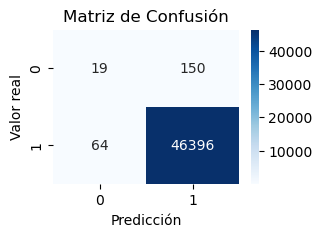

In [24]:
plt.figure(figsize=(3, 2))
sns.heatmap(confusion_matrix(preds.y_real, preds.y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de Confusión")
plt.show()

In [25]:
print('Test Report')
print(classification_report(preds.y_real, preds.y_pred))

Test Report
              precision    recall  f1-score   support

           0       0.23      0.11      0.15       169
           1       1.00      1.00      1.00     46460

    accuracy                           1.00     46629
   macro avg       0.61      0.56      0.57     46629
weighted avg       0.99      1.00      0.99     46629



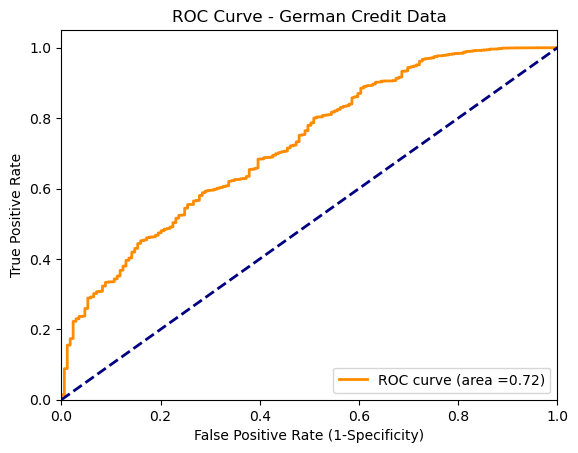

In [26]:
fpr, tpr, threshold = roc_curve(y_test, model.predict_proba(X_testx)[:,1] ) # Valores para la curva ROC

roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area =%0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - German Credit Data')
plt.legend(loc = 'lower right')

### ESTIMACIÓN DE THRESHOLD MEDIANTE FUNCION DE COSTO

En modelos de crédito con clases desbalanceadas, los falsos positivos (aprobar créditos que no se pagarán) son comunes y costosos. Aunque el modelo base es simple, como exigen las entidades que validan scorecards, podemos mejorar su desempeño económico ajustando el threshold de decisión.

Usamos una función de costos que asigna un peso financiero a cada tipo de error. Al evaluar distintos thresholds, elegimos el que minimiza el costo total esperado, sin complicar el modelo.

Este enfoque mantiene la simplicidad del modelo y al mismo tiempo reduce las pérdidas económicas.

In [27]:
def compute_total_cost(threshold, X_test, y_test, model, loan_amnt, fp_cost, fn_cost):
    # Obtener probabilidades del modelo
    probs = model.predict_proba(X_test)[:, 1]
    
    # Generar predicciones según el threshold
    y_pred = (probs > threshold).astype(int)

    # Convertir loan_amnt a array si no lo es ya
    loan_amnt = np.array(loan_amnt)

    # Máscaras booleanas para FP y FN
    fp_mask = (y_pred == 1) & (y_test == 0)
    fn_mask = (y_pred == 0) & (y_test == 1)

    # Suma separada de costos
    fp_total = fp_cost * loan_amnt[fp_mask].sum()
    fn_total = fn_cost * loan_amnt[fn_mask].sum()

    # Retornar la suma total
    return fp_total + fn_total


In [28]:
print(f"Costo total: {compute_total_cost(threshold=0.5, X_test=X_testx, y_test=y_test, model=model, loan_amnt=X_test.loan_amnt, fp_cost=0.87, fn_cost=0.38)}")

Costo total: 2048625.0


In [29]:
thresholds = np.linspace(0, 1, 10000) 
costs = [compute_total_cost(th, X_testx, y_test, model, X_test['loan_amnt'], 0.80, 0.30) for th in thresholds]
min_cost = min(costs)
best_threshold = thresholds[np.argmin(costs)]

print(f"Mejor threshold (grid search): {best_threshold:.6f}")
print(f"Costo total mínimo: {min_cost:.2f}")


Mejor threshold (grid search): 0.796480
Costo total mínimo: 1833220.00


In [30]:
preds['y_pred_cost'] = 0
preds.loc[preds["probs"] > best_threshold, 'y_pred_cost'] = 1
preds

,y_real,y_pred,probs,y_pred_cost
0,1,1,0.997,1
1,1,1,1.000,1
2,1,1,1.000,1
3,1,1,0.997,1
4,1,1,0.999,1
...,...,...,...,...
46624,1,1,0.997,1
46625,1,1,0.991,1
46626,1,1,0.998,1
46627,1,1,0.996,1


## Coeficientes de Gini y Kolgomorov-Smirnov

In [31]:
auc = roc_auc_score(y_test, model.predict_proba(X_testx)[:,1])
gini = 2 * auc - 1
print(f"Coeficiente de Gini: {gini:.3f}")

Coeficiente de Gini: 0.444


In [32]:
df_prediccion = pd.DataFrame({
    'y_true': y_test,            # 0 = malo, 1 = bueno
    'y_pred_prob': model.predict_proba(X_testx)[:,1]   # probabilidades predichas por el modelo
})

# Ordenar por probabilidad descendente
df_prediccion = df_prediccion.sort_values(by='y_pred_prob', ascending=True).reset_index(drop=True)

# Identificar los "malos" como los 0s
df_prediccion['es_bueno'] = df_prediccion['y_true']
df_prediccion['es_malo'] = 1 - df_prediccion['y_true']

# Contadores para acumulados
df_prediccion['n'] = 1

In [33]:
# Totales
total_clientes = df_prediccion['n'].sum()
total_malos = df_prediccion['es_malo'].sum()
total_buenos = df_prediccion['es_bueno'].sum()

# Acumulados
df_prediccion['acum_clientes'] = df_prediccion['n'].cumsum()
df_prediccion['acum_malos'] = df_prediccion['es_malo'].cumsum()
df_prediccion['acum_buenos'] = df_prediccion['es_bueno'].cumsum()

# Porcentajes acumulados para curva de Gini y KS
df_prediccion['% Acumulado Clientes'] = df_prediccion['acum_clientes'] / total_clientes
df_prediccion['% Acumulado Clientes Malos'] = df_prediccion['acum_malos'] / total_malos
df_prediccion['% Acumulado Clientes Buenos'] = df_prediccion['acum_buenos'] / total_buenos

# KS específico
df_prediccion['ks'] = df_prediccion['% Acumulado Clientes Malos'] - df_prediccion['% Acumulado Clientes Buenos']

# KS máximo
ks_stat = df_prediccion['ks'].max()
ks_idx = df_prediccion['ks'].idxmax()
ks_threshold = df_prediccion.loc[ks_idx, 'y_pred_prob']

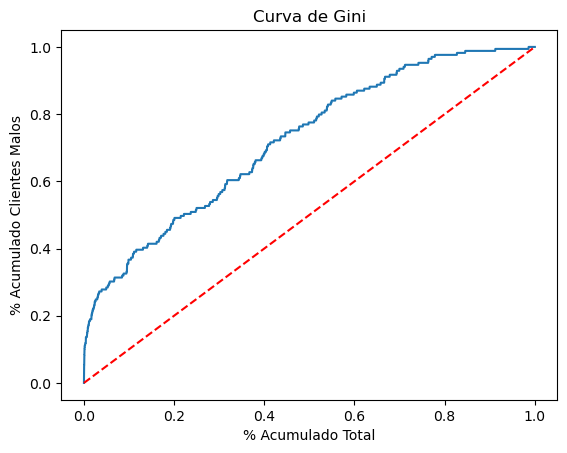

In [34]:
plt.plot(df_prediccion['% Acumulado Clientes'], df_prediccion['% Acumulado Clientes Malos'])
plt.plot(df_prediccion['% Acumulado Clientes'], df_prediccion['% Acumulado Clientes'], linestyle = '--', color = 'red') # Benchmark de predicción aleatoria 50-50
plt.xlabel('% Acumulado Total')
plt.ylabel('% Acumulado Clientes Malos')
plt.title('Curva de Gini')
plt.show()

In [35]:
ks_statistic = max(tpr - fpr)
ks_threshold = thresholds[np.argmax(tpr - fpr)]

print(f"KS statistic: {ks_statistic:.3f} at threshold {ks_threshold:.3f}")

KS statistic: 0.304 at threshold 0.645


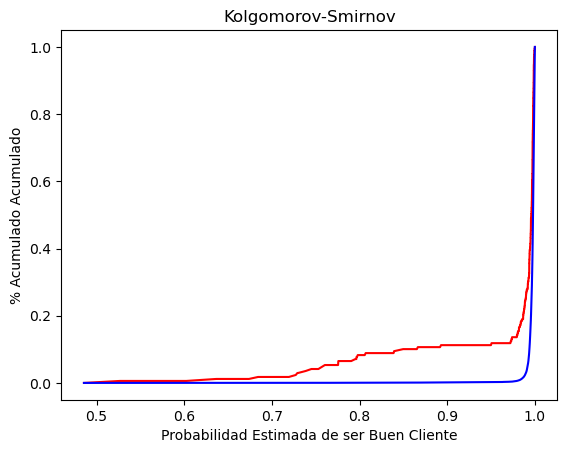

In [36]:
plt.plot(df_prediccion['y_pred_prob'], df_prediccion['% Acumulado Clientes Malos'], color = 'red')
plt.plot(df_prediccion['y_pred_prob'], df_prediccion['% Acumulado Clientes Buenos'], color = 'blue')
plt.xlabel('Probabilidad Estimada de ser Buen Cliente')
plt.ylabel('% Acumulado Acumulado')
plt.title('Kolgomorov-Smirnov')
plt.show()

## SCORE CARD

In [37]:
reference_var = pd.DataFrame({
    'var_independiente': X_train[drop].drop(columns = ['addr_nd', 'dti_bins', 'total_acc_bins', 'annual_inc_bins', 'linea_mesescredito_bins']).columns, 
    'coeficiente': 0, 'pvalue': np.nan
})
summary = pd.concat([summary, reference_var], axis=0)
summary = summary.drop_duplicates(subset='var_independiente', keep='first')
summary['var_original'] = summary.var_independiente.str.split('_').str[0]
summary.reset_index(drop=True, inplace=True)

In [38]:
puntaje_min = 300
puntaje_max = 850

coef_sum_min = summary.groupby('var_original')['coeficiente'].min().sum()
coef_sum_max = summary.groupby('var_original')['coeficiente'].max().sum()

summary['calculo_score'] = summary['coeficiente']  * (puntaje_max - puntaje_min) / (coef_sum_max - coef_sum_min)

summary.loc[0, 'calculo_score'] = (summary.loc[0, 'coeficiente'] - coef_sum_min) * (puntaje_max - puntaje_min) / (coef_sum_max - coef_sum_min) + puntaje_min

summary['score'] = summary.calculo_score.round()

In [39]:
pd.options.display.max_rows = None

summary['round_diff'] = summary.score - summary.calculo_score

prescore_min = summary.groupby('var_original')['score'].min().sum()
prescore_max = summary.groupby('var_original')['score'].max().sum()
print(prescore_max, prescore_min)

852.0 300.0


In [40]:
# Ajuste del puntaje máximo del score card

maximos_idx = summary.groupby('var_original')['score'].idxmax()

summary_maximos = summary.loc[maximos_idx].copy()
summary_maximos['floor_score'] = np.floor(summary_maximos['calculo_score'])
summary_maximos['diff_floor'] = summary_maximos['score'] - summary_maximos['floor_score']

summary_maximos_ordenados = summary_maximos.sort_values('diff_floor', ascending=False)

puntos_a_reducir = 2
reducidos = 0

for idx, row in summary_maximos_ordenados.iterrows():
    diff = int(row['diff_floor'])
    if diff > 0:
        if reducidos + diff <= puntos_a_reducir:
            summary.loc[idx, 'score'] = int(np.floor(summary.loc[idx, 'calculo_score']))
            reducidos += diff
        if reducidos == puntos_a_reducir:
            break

nuevo_prescore_max = summary.groupby('var_original')['score'].max().sum()
print(f'prescore_max tras ajuste: {nuevo_prescore_max}')

prescore_max tras ajuste: 850.0


In [41]:
pd.options.display.max_rows = 10

In [42]:
scorecard = summary.copy()
scorecard

,var_independiente,coeficiente,pvalue,var_original,calculo_score,score,round_diff
0,Intercepto,-0.291,NaN,Intercepto,292.984,292.000,0.016
1,purpose_house_moving_medical,0.437,0.009,purpose,24.111,24.000,-0.111
2,purpose_wedding_vacation,0.628,0.008,purpose,34.624,35.000,0.376
3,grade_d_c,0.866,0.000,grade,47.726,48.000,0.274
4,term_36,-0.233,0.001,term,-12.840,-13.000,-0.160
...,...,...,...,...,...,...,...
55,mnths_since_last_delinq_83_plus,0.000,NaN,mnths,0.000,0.000,0.000
56,delinq_2yrs_5_plus,0.000,NaN,delinq,0.000,0.000,0.000
57,total_acc_0a6,0.000,NaN,total,0.000,0.000,0.000
58,mths_since_last_record_0a3,0.000,NaN,mths,0.000,0.000,0.000


### OTORGANDO SCORES

In [43]:
vars_indp = summary.var_independiente.values

X_test.insert(0, 'Intercepto', 1)
X_test = X_test[vars_indp]

score = scorecard.score
score = score.values.reshape(60,1)

scores = X_test.dot(score)
scores

,0
0,633.000
1,729.000
2,752.000
3,620.000
4,683.000
...,...
46624,637.000
46625,568.000
46626,661.000
46627,606.000


### PROBABILIDAD DE DEFAULT A PARTIR DE LOS SCORES

In [44]:
pd.options.display.float_format = '{:.5f}'.format

sum_coef_scores = ((scores - puntaje_min)/(puntaje_max - puntaje_min)) * (coef_sum_max - coef_sum_min) + coef_sum_min

y_pd_scores = np.exp(sum_coef_scores) / (np.exp(sum_coef_scores) + 1)
PD = pd.concat([y_pd_scores, preds.probs], axis=1)
PD.columns = ['y_PD_scores', 'y_PD_original']
PD

,y_PD_scores,y_PD_original
0,0.99720,0.99723
1,0.99951,0.99951
2,0.99968,0.99968
3,0.99646,0.99652
4,0.99887,0.99888
...,...,...
46624,0.99740,0.99746
46625,0.99096,0.99109
46626,0.99831,0.99834
46627,0.99544,0.99556


### ESTABLECIENDO UN THRESHOLD COMO UN SCORE A PARTIR DE (1 - P)

In [45]:
threshold_score = pd.concat([pd.DataFrame(threshold), pd.DataFrame(fpr), pd.DataFrame(tpr)], axis=1)
threshold_score.columns = ['threshold', 'fpr', 'tpr']
threshold_score.loc[0, 'threshold'] = 1
threshold_score.reset_index(inplace=True, drop=True)
threshold_score

,threshold,fpr,tpr
0,1.00000,0.00000,0.00000
1,0.99988,0.00000,0.00002
2,0.99984,0.00000,0.00032
3,0.99984,0.00000,0.00037
4,0.99983,0.00000,0.00054
...,...,...,...
10703,0.67385,0.98817,0.99994
10704,0.63674,0.99408,0.99994
10705,0.54921,0.99408,0.99998
10706,0.52676,1.00000,0.99998


In [47]:
threshold_score['score'] = ((np.log(threshold_score['threshold'] / (1 - threshold_score['threshold'])) - coef_sum_min) * ((puntaje_max - puntaje_min) / (coef_sum_max - coef_sum_min)) + puntaje_min).round()
threshold_score.loc[0, 'score'] = puntaje_max

def n_aprobados(p): # donde p es la probabilidad del punto de corte
    return np.where(preds['probs'] >= p, 1, 0).sum()

threshold_score['aprobados'] = threshold_score['threshold'].apply(n_aprobados)
threshold_score['rechazados'] = preds['probs'].shape[0] - threshold_score['aprobados']

threshold_score['tasa_aprobacion'] = threshold_score['aprobados'] / preds['probs'].shape[0]
threshold_score['tasa_rechazo'] = 1 - threshold_score['tasa_aprobacion'] 

``threshold_score`` es una tabla que permite relacionar directamente el umbral de probabilidad (threshold) con el score final del modelo, facilitando la interpretación y toma de decisiones adaptado para nuestro modelo de Probabilidad de Default y su correspondiente ScoreCard.

In [48]:
threshold_score

,threshold,fpr,tpr,score,aprobados,rechazados,tasa_aprobación,tasa_aprobacion,tasa_rechazo
0,1.00000,0.00000,0.00000,850.00000,0,46629,0.00000,0.00000,1.00000
1,0.99988,0.00000,0.00002,806.00000,1,46628,0.00002,0.00002,0.99998
2,0.99984,0.00000,0.00032,791.00000,15,46614,0.00032,0.00032,0.99968
3,0.99984,0.00000,0.00037,791.00000,17,46612,0.00036,0.00036,0.99964
4,0.99983,0.00000,0.00054,788.00000,25,46604,0.00054,0.00054,0.99946
...,...,...,...,...,...,...,...,...,...
10703,0.67385,0.98817,0.99994,349.00000,46624,5,0.99989,0.99989,0.00011
10704,0.63674,0.99408,0.99994,340.00000,46625,4,0.99991,0.99991,0.00009
10705,0.54921,0.99408,0.99998,320.00000,46627,2,0.99996,0.99996,0.00004
10706,0.52676,1.00000,0.99998,315.00000,46628,1,0.99998,0.99998,0.00002


In [49]:
#X_test.to_csv(PROCESSED_DATA_PATH / 'X_test_intercepto.csv', index=False)
#threshold_score.to_csv(PROCESSED_DATA_PATH / 'thrshold_score.csv', index=False)
#scorecard.to_csv(PROCESSED_DATA_PATH / 'scorecard_model.csv', index=False)